In [6]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import importlib
import sys

keras = tf.keras
tf.enable_eager_execution()

import matplotlib.pyplot as plt

In [144]:
from euler_self_tf import euler_self_tlist, euler_sde
importlib.reload(sys.modules['euler_self_tf'])
import models as md
importlib.reload(sys.modules['models'])

<module 'models' from '/Users/dave/Documents/GitHub/NN-control/minimal_neural_ode/models.py'>

In [143]:
print(md.oscillator_NNcontrol.__doc__)


    Oscillator with controller defined by dense sequential neural network.
    Suitable for use with batch inputs.
    


# Perturbed oscillator as neural SDE

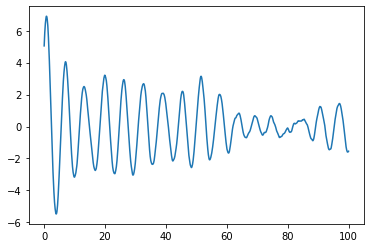

In [12]:
time_steps = 1000
t_free = np.linspace(0, 100, time_steps)
y0_free = tf.cast([[5.], [5.]], tf.float32)

free_trajectory = euler_sde(md.oscillator_sde(), y0_free, t_free, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0])
free_trajectory.shape

plt.plot(t_free,free_trajectory)
plt.show()

# Oscillator with pre-defined linear controller

In [13]:
# Oscillator with controller defined by neural network
class odeModel_oscillator_control(tf.keras.Model):
    
    def __init__(self):
        super(odeModel_oscillator_control, self).__init__()
        self.A = tf.cast([[0, 1],[-1, -0.1]],tf.float32)
        self.k = tf.cast([[0, 0],[-23, -10]],tf.float32)
        
    def forward(self, t, y):
        free = tf.matmul(self.A, y)
        con = tf.matmul(self.k, y)
        dy = tf.add(free, con)
        return (dy, tf.cast([[0.0],[0.5]],tf.float32))

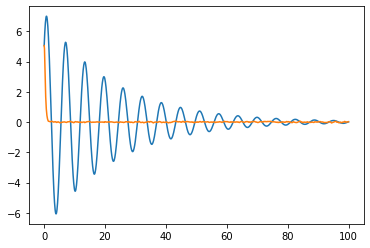

In [113]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0 = tf.cast([[5.], [5.]], tf.float32)

trajectory = euler_sde(odeModel_oscillator_control(), y0, t_grid, 1e-2)
y = np.concatenate(trajectory[:,0])
ydot = np.concatenate(trajectory[:,1])
trajectory.shape

# plt.plot(t_grid,free_trajectory, t_grid,y)
plt.plot(t_free,free_trajectory, t_grid,y)
plt.show()

# Oscillator with NN controller

This basically amounts to learning the matrix k (or a better version thereof) defined above in odeModel_oscillator_control.

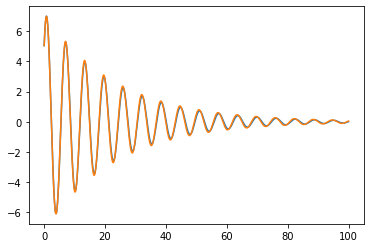

In [145]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0 = tf.cast([[5.], [5.]],tf.float32)

free_trajectory = euler_self_tlist(md.oscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0])

# Run forward evaluation
# trajectory = euler_sde(md.oscillator_NNcontrol_sde(), y0, t_grid, 1e-2)
trajectory = euler_self_tlist(md.oscillator_linear_control(), y0, t_grid, 1e-2)
trajectory = np.concatenate(trajectory[:,0,0])

plt.plot(t_free,free_trajectory, t_grid,trajectory)

# Train

In [ ]:
# # Run simulation niters times, updating parameters on each iteration
# y0 = tf.cast([[0.], [0.]],tf.float32)
# for step in range(niters+1):
    
#     # batch_y0 = get_batch(batch_size) # Random
#     batch_y0 = [y0,y0,y0,y0,y0] # Fixed
    
#     loss = compute_gradients_and_update_path(batch_y0)    
#     loss_history.append(loss.numpy())
    
#     if step % test_freq == 0:        
#         trajectory = euler_sde(model, y0, t_grid, 1e-2)        
#         print(loss)
        
#         trajectory = np.concatenate(trajectory[:,0,0])
#         plt.plot(t_grid,free_trajectory, t_grid,trajectory)
#         plt.legend( ('free oscillator', 'controlled oscillator/system'))
#         plt.show()

In [57]:
def get_batch(batch_size):
    return tf.random_uniform([batch_size,2,1], minval=-15.,maxval=15.)

In [51]:
# Function for gradient evaluation and update

def compute_gradients_and_update_path(model, solver, optimizer, batch_y0):
    with tf.GradientTape() as g:
        
        y_points = solver(model, batch_y0, t_grid, 1e-1)
        loss = tf.reduce_mean(tf.math.square(y_points), axis=0) # Across time
        loss = tf.reduce_mean(loss, axis=0) # Across batches
    
    gradients = g.gradient(loss, model.weights)  # tensorflow gradient computation
    print(gradients)
    optimizer.apply_gradients(zip(gradients, model.weights))
    return loss[0]

compute_gradients_and_update_path = tfe.defun(compute_gradients_and_update_path) # May make the code faster

In [137]:
def train_ode(model, batch_size, niters, test_freq, t_grid, free_trajectory):
    y0 = tf.cast([[5.], [5.]],tf.float32)

    optimizer = tf.train.MomentumOptimizer(learning_rate=1e-5, momentum=0.95)
    
    loss_history = []    

    for step in range(niters+1):
    
        batch_y0 = get_batch(batch_size) # Random
#         batch_y0 = [y0,y0,y0,y0,y0] # Fixed

        loss = compute_gradients_and_update_path(model, euler_self_tlist, optimizer, batch_y0)    
        loss_history.append(loss.numpy())

        if step % test_freq == 0:        
            trajectory = euler_self_tlist(model, y0, t_grid, 1e-2)        
            print(loss)mo

            trajectory = np.concatenate(trajectory[:,0,0])
            plt.plot(t_grid,free_trajectory, t_grid,trajectory)
            plt.legend( ('free oscillator', 'controlled oscillator/system'))
            plt.show()

    return loss_history

In [156]:
def train_sde(model, batch_size, niters, test_freq, t_grid, free_trajectory):
    y0 = tf.cast([[5.], [5.]],tf.float32)

    optimizer = tf.train.MomentumOptimizer(learning_rate=1e-5, momentum=0.95)
    
    loss_history = []    

    for step in range(niters+1):
    
        batch_y0 = get_batch(batch_size) # Random
#         batch_y0 = [y0,y0,y0,y0,y0] # Fixed

        loss = compute_gradients_and_update_path(model, euler_sde, optimizer, batch_y0)    
        loss_history.append(loss.numpy())

        if step % test_freq == 0:        
            trajectory = euler_sde(model, y0, t_grid, 1e-2)        
            print(loss)

            trajectory = np.concatenate(trajectory[:,0,0])
            plt.plot(t_grid,free_trajectory, t_grid,trajectory)
            plt.legend( ('free oscillator', 'controlled oscillator/system'))
            plt.show()

    plt.plot(loss_history)
    plt.yscale("log")
    return loss_history

# Linear NN ode

In [149]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 50, time_steps)

# Free system for comparison
free_trajectory = euler_self_tlist(md.oscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0])

# Initialise new instance of the model
model = md.oscillator_linear_control()
# model = md.oscillator_linear_control()

batch_size = 10
niters = 1000
test_freq = 200

[<tf.Tensor 'AddN_998:0' shape=(2, 1) dtype=float32>, <tf.Tensor 'AddN_999:0' shape=(1,) dtype=float32>]
tf.Tensor([70.95728], shape=(1,), dtype=float32)


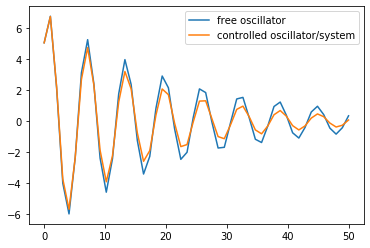

tf.Tensor([3.2892005], shape=(1,), dtype=float32)


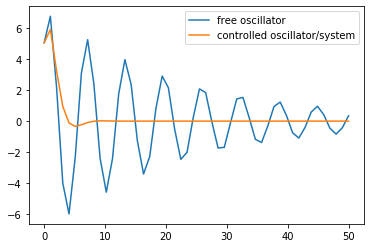

tf.Tensor([2.9333057], shape=(1,), dtype=float32)


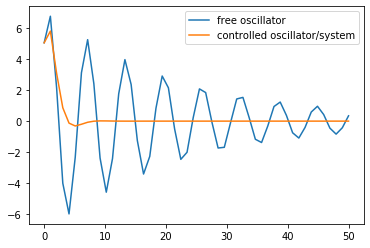

tf.Tensor([2.8420033], shape=(1,), dtype=float32)


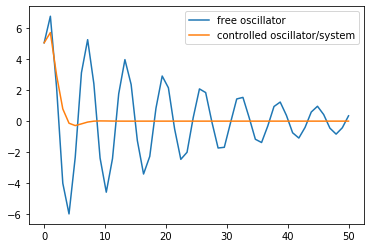

tf.Tensor([3.1782262], shape=(1,), dtype=float32)


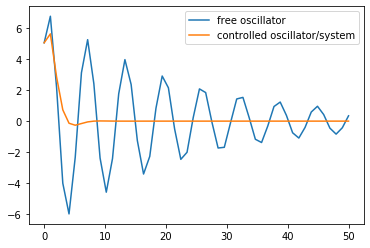

tf.Tensor([4.7096977], shape=(1,), dtype=float32)


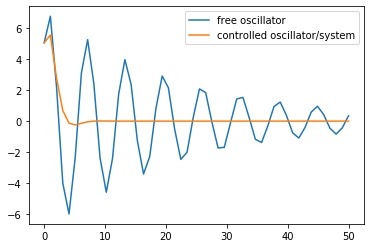

In [150]:
loss_history = train_ode(model, batch_size, niters, test_freq, t_grid, free_trajectory)

In [148]:
model.weights

[<tf.Variable 'dense_55/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[ 0.08893956],
        [-1.1534396 ]], dtype=float32)>,
 <tf.Variable 'dense_55/bias:0' shape=(1,) dtype=float32, numpy=array([-0.00102911], dtype=float32)>]

# Non-linear NN ode

In [151]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 50, time_steps)

# Free system for comparison
free_trajectory = euler_self_tlist(md.oscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0])

# Initialise new instance of the model
model = md.oscillator_NNcontrol()

batch_size = 10
niters = 100
test_freq = 20

In [160]:
loss_history = train_ode(model, batch_size, niters, test_freq, t_grid, free_trajectory)

# Linear NN SDE

In [163]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 50, time_steps)

# Free system for comparison
free_trajectory = euler_self_tlist(md.oscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0])

# Initialise new instance of the model
model = md.oscillator_linear_control_sde()

batch_size = 50
niters = 100
test_freq = 20

[<tf.Tensor 'AddN_998:0' shape=(2, 1) dtype=float32>, <tf.Tensor 'AddN_999:0' shape=(1,) dtype=float32>]
tf.Tensor([1.908462], shape=(1,), dtype=float32)


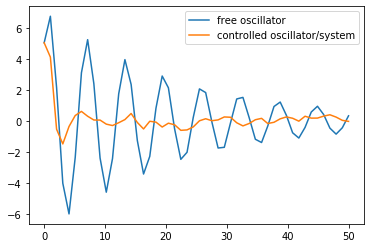

tf.Tensor([2.1925528], shape=(1,), dtype=float32)


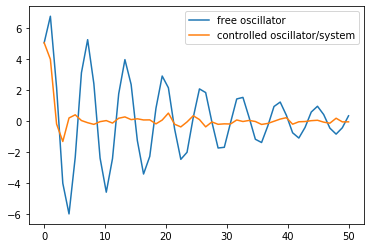

tf.Tensor([2.1370554], shape=(1,), dtype=float32)


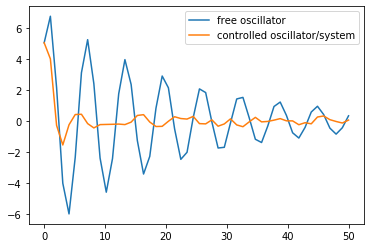

tf.Tensor([2.1834047], shape=(1,), dtype=float32)


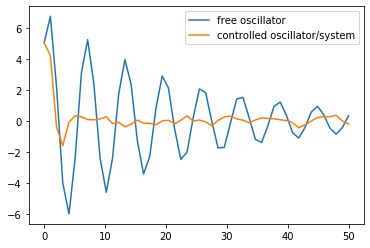

tf.Tensor([2.5632877], shape=(1,), dtype=float32)


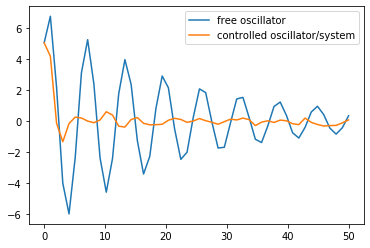

tf.Tensor([1.9575546], shape=(1,), dtype=float32)


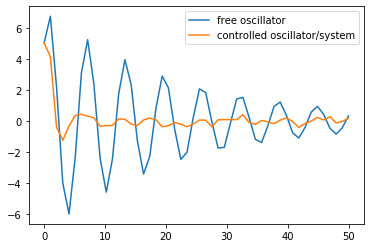

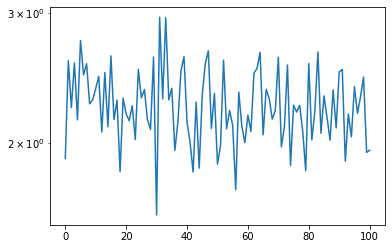

In [164]:
loss_history = train_sde(model, batch_size, niters, test_freq, t_grid, free_trajectory)

# Non-linear NN SDE

In [161]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 50, time_steps)

# Free system for comparison
free_trajectory = euler_self_tlist(md.oscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0])

# Initialise new instance of the model
model = md.oscillator_NNcontrol_sde()

batch_size = 50
niters = 100
test_freq = 20

[<tf.Tensor 'AddN_998:0' shape=(2, 50) dtype=float32>, <tf.Tensor 'AddN_999:0' shape=(50,) dtype=float32>, <tf.Tensor 'AddN_1000:0' shape=(50, 1) dtype=float32>, <tf.Tensor 'AddN_1001:0' shape=(1,) dtype=float32>]
tf.Tensor([30.953192], shape=(1,), dtype=float32)


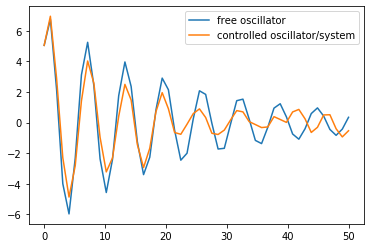

tf.Tensor([5.415774], shape=(1,), dtype=float32)


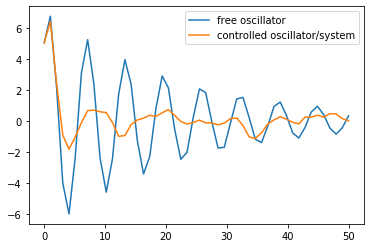

tf.Tensor([4.413645], shape=(1,), dtype=float32)


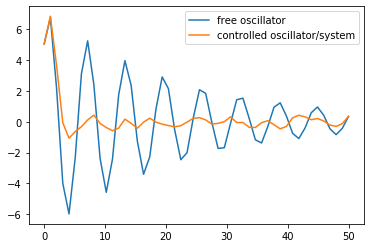

tf.Tensor([4.022311], shape=(1,), dtype=float32)


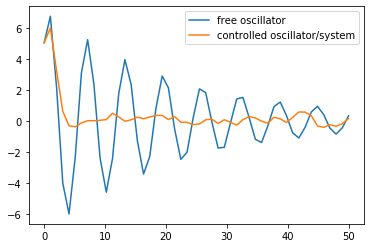

tf.Tensor([3.6120725], shape=(1,), dtype=float32)


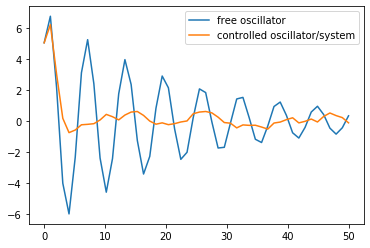

tf.Tensor([3.8122454], shape=(1,), dtype=float32)


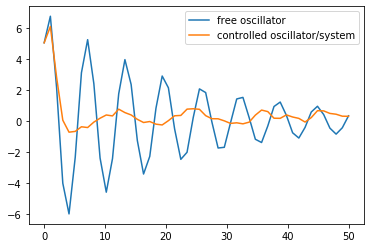

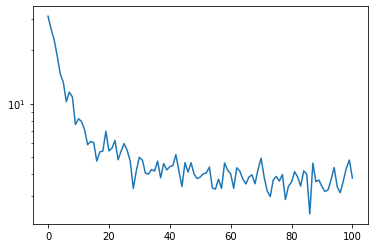

In [162]:
loss_history = train_sde(model, batch_size, niters, test_freq, t_grid, free_trajectory)